In [3]:
# Cloning YOLO github
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt
!pip install utils
!pip install pylabel > /dev/null

fatal: destination path 'yolov5' already exists and is not an empty directory.


# Importing the Necessary Libraries

In [18]:
import torch
import os 
import random
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import logging
import os 
import zipfile
import yaml
import PIL

from IPython.display import Image  # for displaying images
from sklearn.model_selection import train_test_split
from pylabel import importer
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw

logging.getLogger().setLevel(logging.CRITICAL)
random.seed(42)

# Convert COCO JSON Annotations to YOLO TXT Files

In [19]:
from pylabel import importer

## Import COCO Annotations 

In [20]:
# Copy images_raw to working directory
# Note: This may take some time depending on the size of your images_raw folder
!cp -r ../input/plastic-paper-garbage-bag-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/images_raw ./
!cp -r /kaggle/input/plastic-paper-garbage-bag-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/coco_instances.json ./

In [21]:
# Copy annotations to working directory
!cp -r  /kaggle/input/cigarette-butt/images/train ./

In [6]:
# Copy test image to output directory
!cp -r ../input/plastic-paper-garbage-bag-synthetic-images/ImageClassesCombinedWithCOCOAnnotations/test_image.jpg ./

In [22]:
#Specify path to the coco.json file
path_to_annotations = r"./coco_instances.json"
#Specify the path to the images (if they are in a different folder than the annotations)
path_to_images = r"./images_raw"

#Import the dataset into the pylable schema 
dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="BCCD_coco")
path_to_cigar_anno = r"./train"
for file in os.path.listdir(path_to_cigar_anno):
    print(file)

AttributeError: module 'posixpath' has no attribute 'listdir'

## Analyze annotations
Pylabel can calculate basic summary statisticts about the dataset such as the number of files and the classes. 
The dataset is stored as a pandas frame so the developer can do additional exploratory analysis on the dataset. 

In [9]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")
print(f"Path to annotations:\n{dataset.path_to_annotations}")


Number of images: 15000
Number of classes: 3
Classes:['garbage', 'paper', 'plastic']
Class counts:
garbage    10062
paper       9967
plastic     9903
Name: cat_name, dtype: int64
Path to annotations:
.


## Visualize Annotations 
You can render the bounding boxes for your image to inspect them and confirm that they imported correctly.  

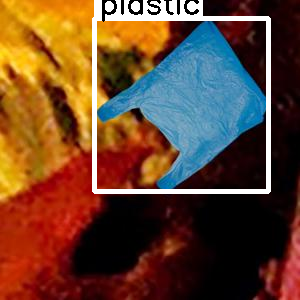

In [10]:
try:
    display(dataset.visualize.ShowBoundingBoxes(2))
    display(dataset.visualize.ShowBoundingBoxes("./images_raw/00000002.jpg"))
except:
    pass

## Export to YOLOv5 Format 

In [11]:
# This cell may take some time depending on the size of the dataset.
dataset.path_to_annotations = "labels"
dataset.export.ExportToYoloV5(output_path='text_files');

Exporting YOLO files...: 100%|██████████| 15000/15000 [01:35<00:00, 156.74it/s]


In [12]:
# Note!!! Only run this code once
path = './text_files' #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")


# Splitting the Dataset

In [13]:
# Read images and annotations
image_dir = r'./images_raw'
images = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
annotations = [os.path.join('./text_files', x) for x in os.listdir('./text_files') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [14]:
len(train_images),len(train_annotations)

(12000, 12000)

# Format Directories


In [15]:
!mkdir images
!mkdir annotations
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [16]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [17]:
!mv annotations labels

Move images folder inside the yolov5 directory

In [18]:
shutil.move("./images", "./yolov5")

'./yolov5/images'

Move labels folder inside the yolov5 directory

In [19]:
shutil.move("./labels", "./yolov5")

'./yolov5/labels'

# Adjusting the dataset.yaml file

* `path`: images
* `train`: train
* `val`: val
* `test`: test


In [20]:
# Viewing the original unprocessed yaml file

yaml_params = {}
with open(r'dataset.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    yaml_file_list = yaml.load(file, Loader=yaml.FullLoader)
    yaml_params = yaml_file_list
    print(yaml_file_list)

{'names': ['garbage', 'paper', 'plastic'], 'nc': 3, 'path': '..', 'train': 'images', 'val': 'images'}


In [21]:
# Adjusting the parameters of the yaml file
yaml_params['path'] = 'images'
yaml_params['train'] = 'train'
yaml_params['val'] = 'val'
yaml_params['test'] = 'test'
yaml_params

{'names': ['garbage', 'paper', 'plastic'],
 'nc': 3,
 'path': 'images',
 'train': 'train',
 'val': 'val',
 'test': 'test'}

In [22]:
# Overwriting the new params from the previous ones.
with open(r'dataset.yaml', 'w') as file:
    documents = yaml.dump(yaml_params, file)

In [23]:
# Moving the dataset.yaml inside the yolov5/data folder.
shutil.move("dataset.yaml", "yolov5/data")

'yolov5/data/dataset.yaml'

In [24]:
shutil.move("./test_image.jpg", "./yolov5")

'./yolov5/test_image.jpg'

# Training the Custom Dataset using YOLOv5

Now, we train the network. We use various flags to set options regarding training.

In [25]:
# Change the current directory inisde the yolov5
%cd ./yolov5

/kaggle/working/yolov5


## Training using YOLOv5

In [42]:
!python train.py --img 300 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 20 --data dataset.yaml --weights yolov5s.pt --workers 24 --name yolo_bag_det

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=dataset.yaml, hyp=hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=300, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_bag_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.co

# Running Inferenece on the Test Data

There are many ways to run inference using the detect.py file.

The source flag defines the source of our detector, which can be:

* A single image
* A folder of images
* Video
* Webcam

...and various other formats. We want to run it over our test images so we set the source flag to .. yolov5/images/test.

The weights flag defines the path of the model which we want to run our detector with.
conf flag is the thresholding objectness confidence.
name flag defines where the detections are stored. We set this flag to yolo_road_det; therefore, the detections would be stored in runs/detect/yolo__det/.
With all options decided, let us run inference over our test dataset.

In [ ]:
!python detect.py --source images/test --weights runs/train/yolo_bag_det/weights/best.pt --conf 0.25 --name yolo_bag_det

In [ ]:
detections_dir = "runs/detect/yolo_bag_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    random_detection_image = PIL.Image.open(random.choice(detection_images))
    ax.imshow(random_detection_image)


# Predict on our own Test Image

In [43]:

!python detect.py --source 0 --weights runs/train/yolo_bag_det/weights/best.pt --conf 0.25 --name yolo_bag_det

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
detections_dir = "runs/detect/yolo_bag_det2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]
random_detection_image = PIL.Image.open(random.choice(detection_images))
plt.figure(figsize=(30,30));
plt.imshow(random_detection_image)
plt.xticks([])
plt.yticks([]);